In [62]:
import pandas as pd
import numpy as np 
from math import *
import os 

import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from colorama import Fore, Style

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE

import lightgbm as lgb

from functools import partial
import optuna
from optuna.integration import LightGBMPruningCallback

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, log_loss, brier_score_loss, mean_squared_error, cohen_kappa_score, matthews_corrcoef
from sklearn.calibration import calibration_curve
import joblib 

# Step 1 : Load and Explore Data

In [63]:
if os.path.exists('data/datasets/dataset_credit_fraud.csv'):
    df = pd.read_csv('data/datasets/dataset_credit_fraud.csv')
    size = df.shape[0]
    part_size = size // 4
    df1 = df[0:part_size]
    df1.to_csv('data/datasets/dataset_credit_fraud_1.csv', index=False)
    df2 = df[part_size:part_size*2]
    df2.to_csv('data/datasets/dataset_credit_fraud_2.csv', index=False)
    df3 = df[part_size*2:part_size*3]
    df3.to_csv('data/datasets/dataset_credit_fraud_3.csv', index=False)
    df4 = df[part_size*3:size]
    df4.to_csv('data/datasets/dataset_credit_fraud_4.csv', index=False)
else :
    df1 = pd.read_csv('data/datasets/dataset_credit_fraud_1.csv')
    df2 = pd.read_csv('data/datasets/dataset_credit_fraud_2.csv')
    df3 = pd.read_csv('data/datasets/dataset_credit_fraud_3.csv')
    df4 = pd.read_csv('data/datasets/dataset_credit_fraud_4.csv')
    df = pd.concat([df1, df2, df3, df4], ignore_index=True)
    df.to_csv('data/datasets/dataset_credit_fraud.csv', index=False)
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [64]:
df.loc[0]

Unnamed: 0                                              0
trans_date_trans_time                 2019-01-01 00:00:18
cc_num                                   2703186189652095
merchant                       fraud_Rippin, Kub and Mann
category                                         misc_net
amt                                                  4.97
first                                            Jennifer
last                                                Banks
gender                                                  F
street                                     561 Perry Cove
city                                       Moravian Falls
state                                                  NC
zip                                                 28654
lat                                               36.0788
long                                             -81.1781
city_pop                                             3495
job                             Psychologist, counselling
dob           

In [65]:
df_fraud = df[df['is_fraud'] == 1]
print(df_fraud.shape)
df_fraud.head()

(7506, 23)


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
2449,2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1
2472,2472,2019-01-02 01:47:29,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1
2523,2523,2019-01-02 03:05:23,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1
2546,2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1
2553,2553,2019-01-02 03:55:47,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1


# Step 2 : Data Preprocessing

In [66]:
df = df.rename(columns={'amt': 'amount', 'dob': 'date_of_birth'})

df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day
df['trans_month'] = df['trans_date_trans_time'].dt.month
# df['trans_year'] = df['trans_date_trans_time'].dt.year

df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['birth_year'] = df['date_of_birth'].dt.year

def haversine(lat1, long1, lat2, long2):
    R = 6371000
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(long2 - long1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return (R * c) / 1000.0   # return km
df['distance'] = haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [67]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amount', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'date_of_birth', 'trans_num',
       'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'trans_hour',
       'trans_day', 'trans_month', 'birth_year', 'distance'],
      dtype='object')

In [68]:
columns_to_drop = ['Unnamed: 0','trans_date_trans_time', 'first', 'last', 'street', 'zip', 'lat', 'long', 'date_of_birth', 'trans_num', 'merch_lat', 'merch_long']
df = df.drop(columns=columns_to_drop)
print(df.shape)
df.head()

(1296675, 16)


,cc_num,merchant,category,amount,gender,city,state,city_pop,job,unix_time,is_fraud,trans_hour,trans_day,trans_month,birth_year,distance
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,3495,"Psychologist, counselling",1325376018,0,0,1,1,1988,78.597568
1,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,149,Special educational needs teacher,1325376044,0,0,1,1,1978,30.212176
2,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,4154,Nature conservation officer,1325376051,0,0,1,1,1962,108.206083
3,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,1939,Patent attorney,1325376076,0,0,1,1,1967,95.673231
4,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,99,Dance movement psychotherapist,1325376186,0,0,1,1,1986,77.556744


In [69]:
df.columns

Index(['cc_num', 'merchant', 'category', 'amount', 'gender', 'city', 'state',
       'city_pop', 'job', 'unix_time', 'is_fraud', 'trans_hour', 'trans_day',
       'trans_month', 'birth_year', 'distance'],
      dtype='object')

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   cc_num       1296675 non-null  int64  
 1   merchant     1296675 non-null  object 
 2   category     1296675 non-null  object 
 3   amount       1296675 non-null  float64
 4   gender       1296675 non-null  object 
 5   city         1296675 non-null  object 
 6   state        1296675 non-null  object 
 7   city_pop     1296675 non-null  int64  
 8   job          1296675 non-null  object 
 9   unix_time    1296675 non-null  int64  
 10  is_fraud     1296675 non-null  int64  
 11  trans_hour   1296675 non-null  int32  
 12  trans_day    1296675 non-null  int32  
 13  trans_month  1296675 non-null  int32  
 14  birth_year   1296675 non-null  int32  
 15  distance     1296675 non-null  float64
dtypes: float64(2), int32(4), int64(4), object(6)
memory usage: 138.5+ MB


In [71]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
cc_num,1296675.0,NaN,NaN,NaN,417192042079726656.0,1308806447000240384.0,60416207185.0,180042946491150.0,3521417320836166.0,4642255475285942.0,4992346398065154048.0
merchant,1296675,693,fraud_Kilback LLC,4403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
category,1296675,14,gas_transport,131659,NaN,NaN,NaN,NaN,NaN,NaN,NaN
amount,1296675.0,NaN,NaN,NaN,70.351035,160.316039,1.0,9.65,47.52,83.14,28948.9
gender,1296675,2,F,709863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1296675,894,Birmingham,5617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,1296675,51,TX,94876,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city_pop,1296675.0,NaN,NaN,NaN,88824.440563,301956.360689,23.0,743.0,2456.0,20328.0,2906700.0
job,1296675,494,Film/video editor,9779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
unix_time,1296675.0,NaN,NaN,NaN,1349243636.726123,12841278.423359,1325376018.0,1338750742.5,1349249747.0,1359385375.5,1371816817.0


In [72]:
df.isna().sum()

cc_num         0
merchant       0
category       0
amount         0
gender         0
city           0
state          0
city_pop       0
job            0
unix_time      0
is_fraud       0
trans_hour     0
trans_day      0
trans_month    0
birth_year     0
distance       0
dtype: int64

In [73]:
df.isnull().sum()

cc_num         0
merchant       0
category       0
amount         0
gender         0
city           0
state          0
city_pop       0
job            0
unix_time      0
is_fraud       0
trans_hour     0
trans_day      0
trans_month    0
birth_year     0
distance       0
dtype: int64

In [74]:
df.duplicated().sum()

np.int64(0)

# Step 3: Data Visualization

In [75]:
continuous_features = ['amount', 'city_pop', 'unix_time', 'trans_hour', 'trans_day', 'trans_month', 'birth_year', 'distance']
n_plot_features = len(continuous_features)

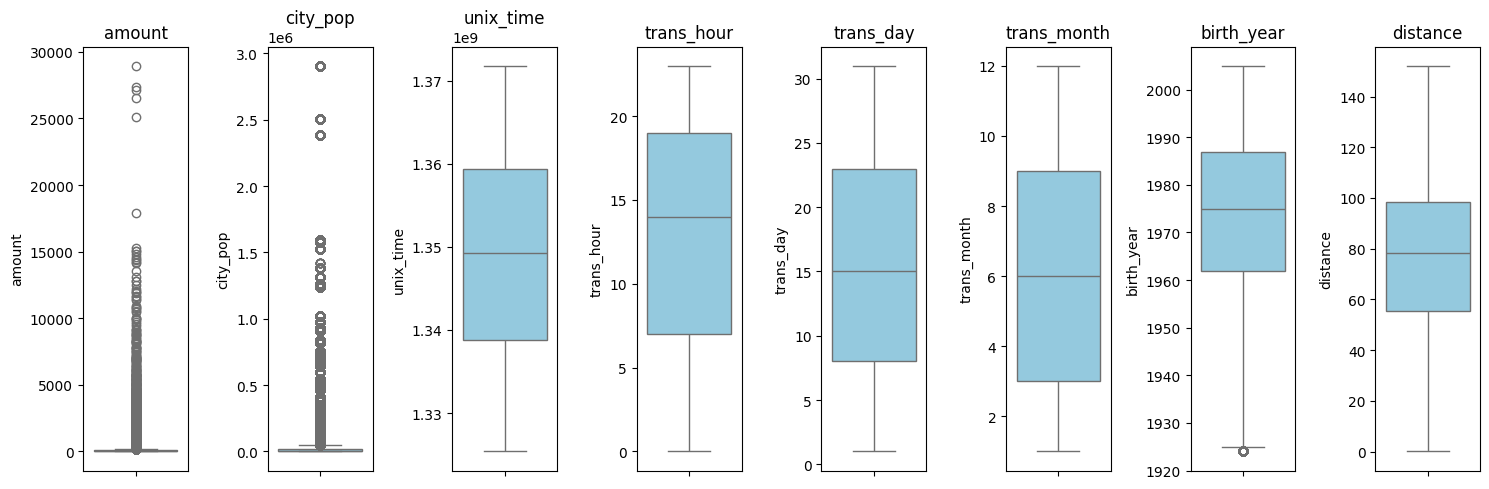

In [76]:
plt.figure(figsize=(15,5))
for i, col in enumerate(continuous_features):
    plt.subplot(1, n_plot_features, i+1)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(col)
plt.tight_layout()
plt.show()

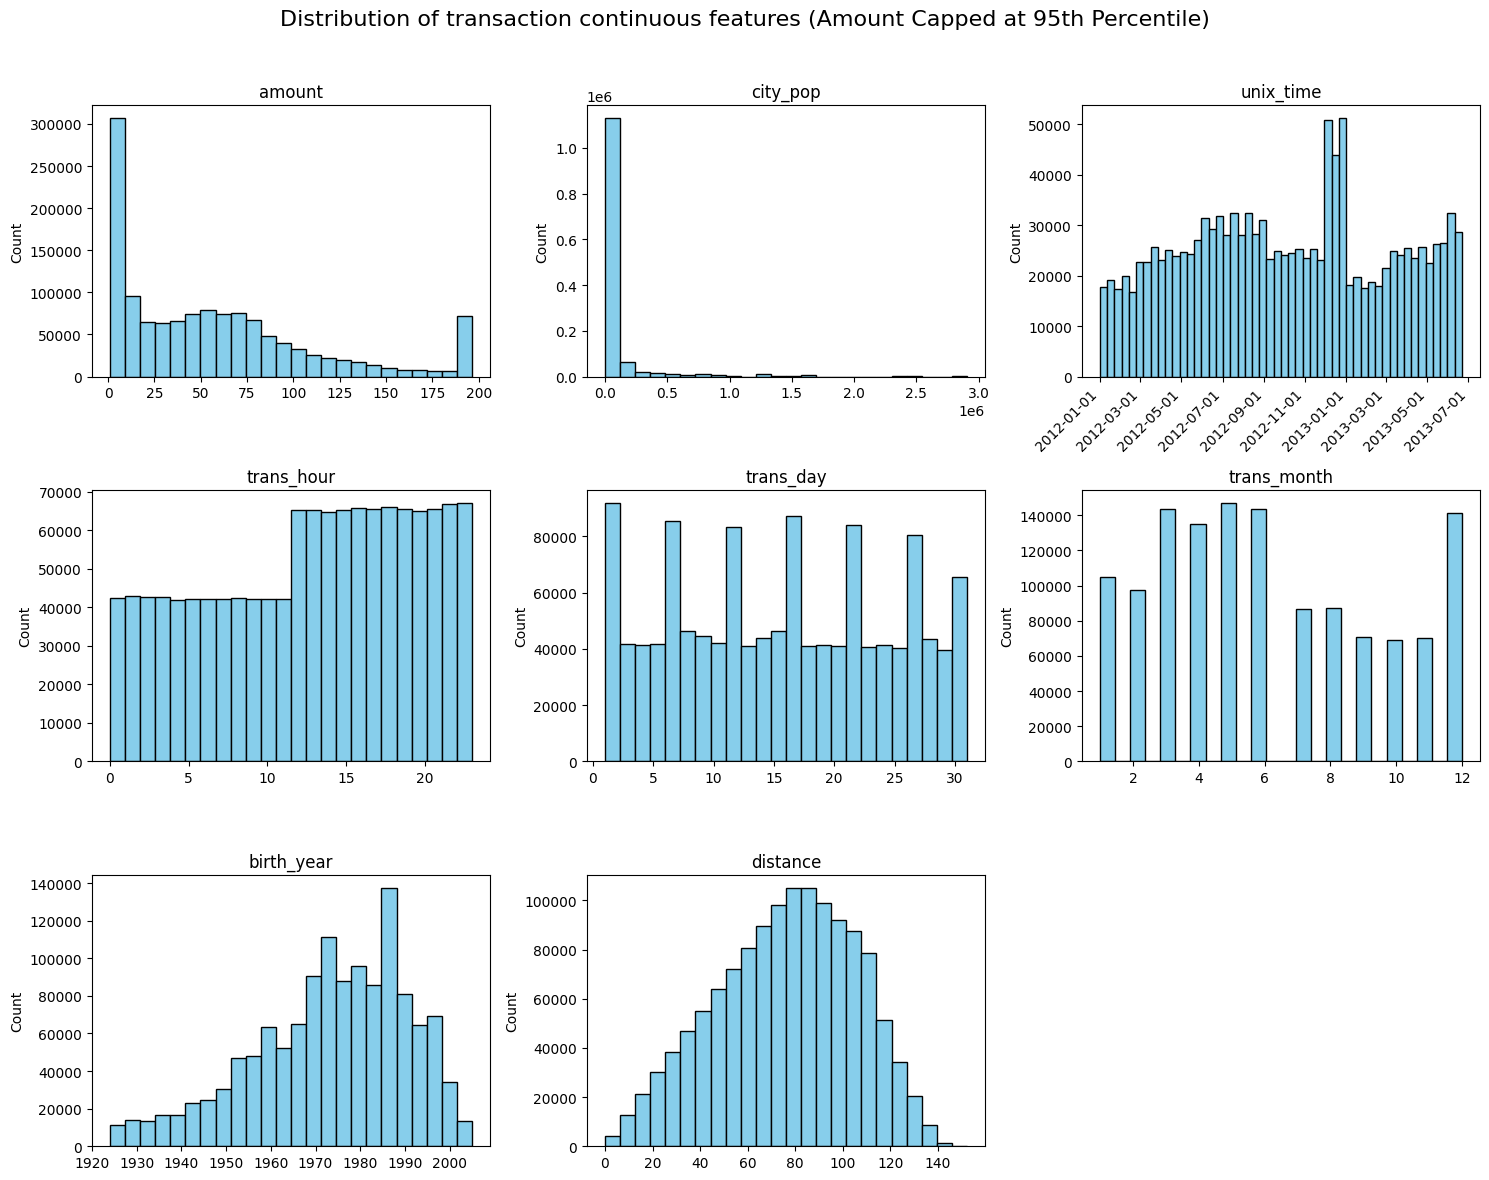

In [77]:
df_copy = df.copy() 
q95 = df_copy['amount'].quantile(0.95)
df_copy['amount'] = df_copy['amount'].clip(upper=q95)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
axes = axes.flatten()
for i, col in enumerate(continuous_features):
    if col == 'unix_time':
        dates = pd.to_datetime(df_copy[col], unit='s')
        axes[i].hist(dates, bins=50, edgecolor='black', color='skyblue')
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        axes[i].xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')
    else:
        axes[i].hist(df_copy[col], bins=24, edgecolor='black', color='skyblue')
    axes[i].set_title(col, fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.suptitle("Distribution of transaction continuous features (Amount Capped at 95th Percentile)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [78]:
categorical_features = ['merchant', 'category', 'gender', 'cc_num', 'city', 'state', 'job']

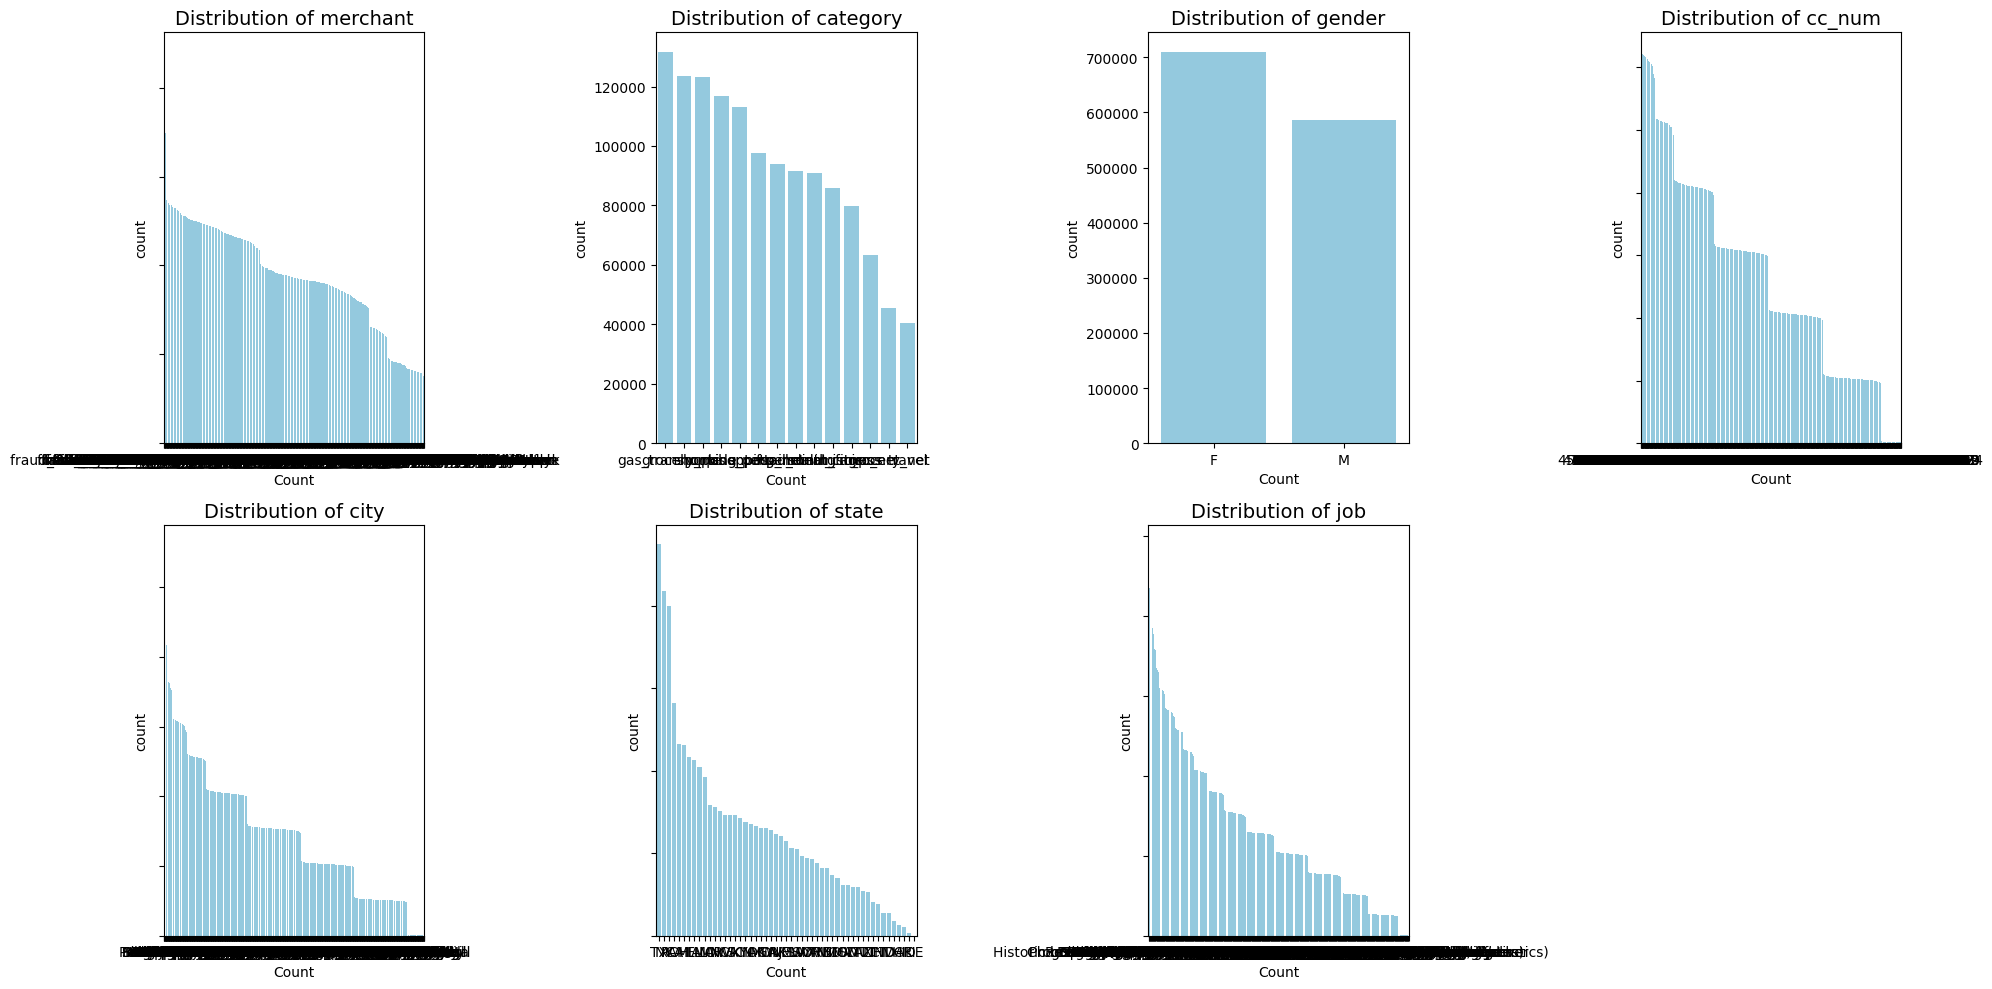

In [79]:
plt.figure(figsize=(20,10))
for i, col in enumerate(categorical_features):
    ax = plt.subplot(2, 4, i+1)
    order = df[col].value_counts().index
    sns.countplot(data=df, x=col, color='skyblue', order=order, ax=ax)
    ax.set_title(f"Distribution of {col}", fontsize=14)
    ax.set_xlabel('Count')
    if len(df[col].unique()) > 20:
        ax.set_yticklabels([])
    else:
        ax.tick_params(axis='x', rotation=0)
plt.tight_layout()
plt.show()

In [80]:
df.groupby('category')['amount'].mean()

category
entertainment      64.210421
food_dining        51.086905
gas_transport      63.434572
grocery_net        53.670084
grocery_pos       116.960986
health_fitness     54.182140
home               58.270139
kids_pets          57.536871
misc_net           80.865095
misc_pos           62.890999
personal_care      47.967678
shopping_net       88.424076
shopping_pos       79.779155
travel            111.504720
Name: amount, dtype: float64

In [81]:
df.groupby('gender')['amount'].mean()

gender
F    70.200324
M    70.533350
Name: amount, dtype: float64

In [82]:
df.pivot_table(values='amount', index='gender', columns='category')

category,entertainment,food_dining,gas_transport,grocery_net,grocery_pos,health_fitness,home,kids_pets,misc_net,misc_pos,personal_care,shopping_net,shopping_pos,travel
gender,,,,,,,,,,,,,,
F,67.125842,50.440567,62.057143,55.832594,136.593229,51.385006,55.024740,57.192930,82.184021,67.673644,48.231986,85.461216,78.776697,62.403437
M,61.144602,51.813030,65.131304,50.961428,94.905817,57.296538,61.933193,57.968028,79.164964,57.453894,47.556855,92.308408,81.171382,159.972515


In [83]:
df['is_fraud'].value_counts(normalize=True) * 100

is_fraud
0    99.421135
1     0.578865
Name: proportion, dtype: float64

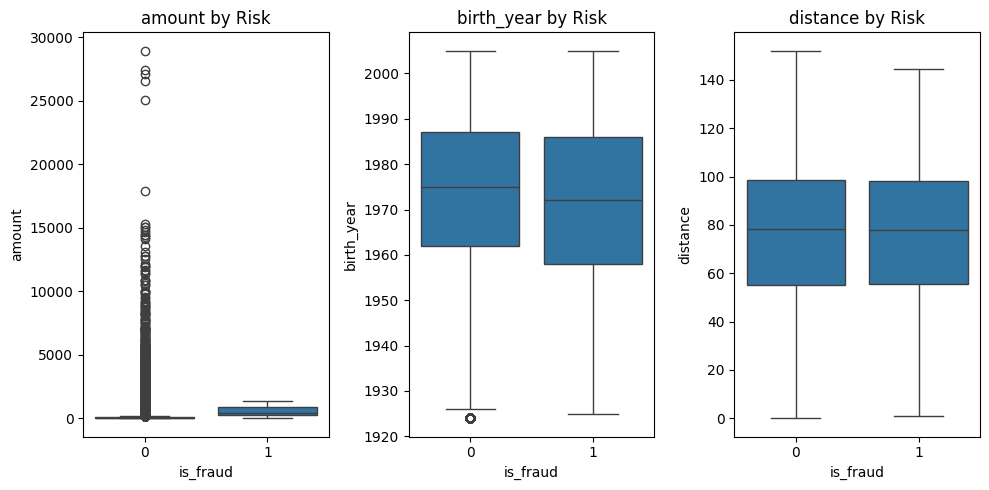

In [84]:
plt.figure(figsize=(10,5))
for i, col in enumerate(['amount', 'birth_year', 'distance']):
    plt.subplot(1,3, i+1)
    sns.boxplot(data=df, x='is_fraud', y=col)
    plt.title(f"{col} by Risk")
plt.tight_layout()
plt.show()

In [85]:
df.groupby('is_fraud')[['amount', 'birth_year', 'distance']].mean()

,amount,birth_year,distance
is_fraud,,,
0,67.667110,1973.273869,76.113756
1,531.320092,1970.438316,76.268330


# Step 4 : Feature Engineering

In [86]:
features = ['merchant', 'category', 'amount', 'gender', 'cc_num', 'city', 'state', 'city_pop', 'job', 'unix_time', 'trans_hour', 'trans_day', 'trans_month', 'birth_year', 'distance']
X = df[features]
y = df['is_fraud']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(907672, 15) (194501, 15) (194502, 15)
(907672,) (194501,) (194502,)


In [87]:
X.loc[0]

merchant       fraud_Rippin, Kub and Mann
category                         misc_net
amount                               4.97
gender                                  F
cc_num                   2703186189652095
city                       Moravian Falls
state                                  NC
city_pop                             3495
job             Psychologist, counselling
unix_time                      1325376018
trans_hour                              0
trans_day                               1
trans_month                             1
birth_year                           1988
distance                        78.597568
Name: 0, dtype: object

In [88]:
categorical_features = ['merchant', 'category', 'gender', 'cc_num', 'city', 'state', 'job']
encoders = {}
for col in categorical_features:
    encoders[col] = LabelEncoder()
    X_train[col] = encoders[col].fit_transform(X_train[col])
    X_val[col] = encoders[col].transform(X_val[col])
    X_test[col] = encoders[col].transform(X_test[col])
    print(f"\nColumn: {col}")
    print("Original classes:", list(encoders[col].classes_))
    print("Encoded values:  ", list(range(len(encoders[col].classes_))))


Column: merchant
Original classes: ['fraud_Abbott-Rogahn', 'fraud_Abbott-Steuber', 'fraud_Abernathy and Sons', 'fraud_Abshire PLC', 'fraud_Adams, Kovacek and Kuhlman', 'fraud_Adams-Barrows', 'fraud_Altenwerth, Cartwright and Koss', 'fraud_Altenwerth-Kilback', 'fraud_Ankunding LLC', 'fraud_Ankunding-Carroll', 'fraud_Armstrong, Walter and Gottlieb', 'fraud_Auer LLC', 'fraud_Auer-Mosciski', 'fraud_Auer-West', 'fraud_Bahringer Group', 'fraud_Bahringer, Bergnaum and Quitzon', 'fraud_Bahringer, Osinski and Block', 'fraud_Bahringer, Schoen and Corkery', 'fraud_Bahringer-Larson', 'fraud_Bahringer-Streich', 'fraud_Bailey-Morar', 'fraud_Balistreri-Nader', 'fraud_Barrows PLC', 'fraud_Bartoletti and Sons', 'fraud_Bartoletti-Wunsch', 'fraud_Barton Inc', 'fraud_Barton LLC', 'fraud_Bashirian Group', 'fraud_Bauch-Blanda', 'fraud_Bauch-Raynor', 'fraud_Baumbach Ltd', 'fraud_Baumbach, Feeney and Morar', 'fraud_Baumbach, Hodkiewicz and Walsh', 'fraud_Baumbach, Strosin and Nicolas', 'fraud_Bechtelar-Rippi

In [89]:
continuous_features = ['amount', 'city_pop', 'unix_time', 'trans_hour', 'trans_day', 'trans_month', 'birth_year', 'distance']
scalers = {}
for col in continuous_features:
    print(f"\nColumn: {col}")
    print("Original ranges: from ", X_train[col].min(), " to ", X_train[col].max())
    scalers[col] = RobustScaler()
    X_train[col] = scalers[col].fit_transform(X_train[[col]])
    X_val[col] = scalers[col].transform(X_val[[col]])
    X_test[col] = scalers[col].transform(X_test[[col]])
    print("Scaled ranges: from ", X_train[col].min(), " to ", X_train[col].max()) 


Column: amount
Original ranges: from  1.0  to  27390.12
Scaled ranges: from  -0.633002582574419  to  371.6535272529564

Column: city_pop
Original ranges: from  23  to  2906700
Scaled ranges: from  -0.12422772529997447  to  148.2892009190707

Column: unix_time
Original ranges: from  1325376044  to  1371816817
Scaled ranges: from  -1.1568757618464223  to  1.094098095919384

Column: trans_hour
Original ranges: from  0  to  23
Scaled ranges: from  -1.1666666666666667  to  0.75

Column: trans_day
Original ranges: from  1  to  31
Scaled ranges: from  -0.9333333333333333  to  1.0666666666666667

Column: trans_month
Original ranges: from  1  to  12
Scaled ranges: from  -0.8333333333333334  to  1.0

Column: birth_year
Original ranges: from  1924  to  2005
Scaled ranges: from  -2.04  to  1.2

Column: distance
Original ranges: from  0.022254515638296817  to  152.11717310594904
Scaled ranges: from  -1.8120465854261918  to  1.713655073910111


In [90]:
target = 'is_fraud'
encoders[target] = LabelEncoder()
y_train = encoders[target].fit_transform(y_train)
y_val = encoders[target].transform(y_val)
y_test = encoders[target].transform(y_test)
print(f"\nColumn: {target}")
print("Original classes:", list(encoders[target].classes_))
print("Encoded values:  ", list(range(len(encoders[target].classes_))))
all_y_labels = np.arange(len(encoders[target].classes_))


Column: is_fraud
Original classes: [np.int64(0), np.int64(1)]
Encoded values:   [0, 1]


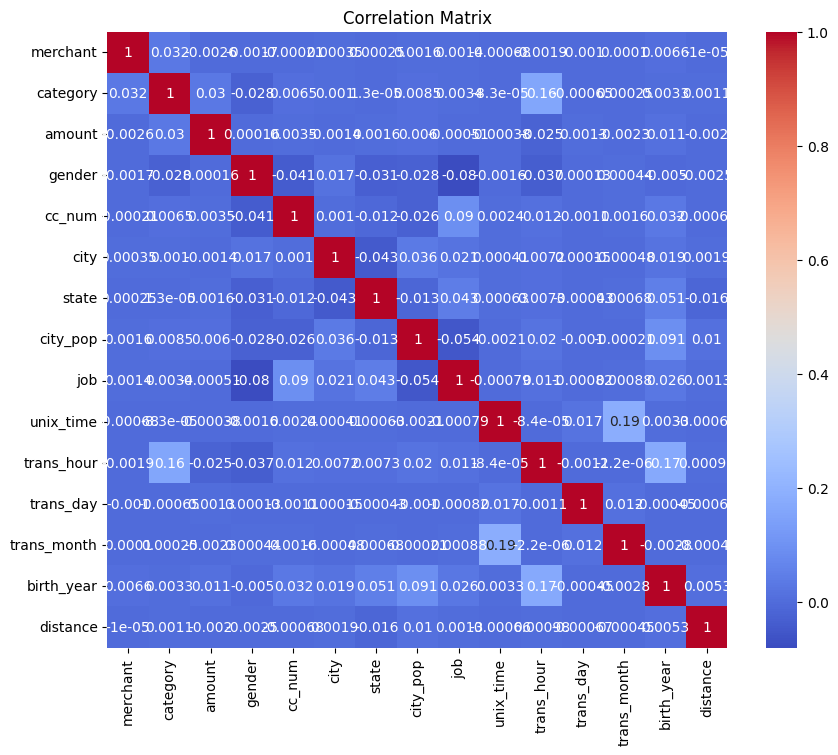

In [91]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

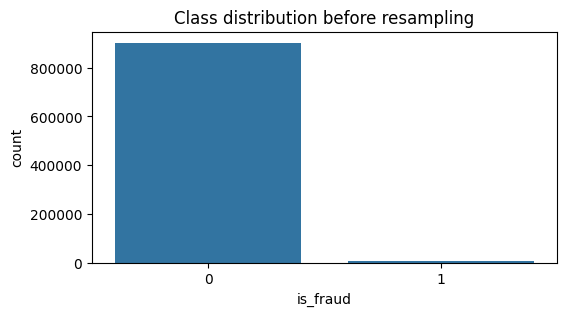

In [92]:
plt.figure(figsize=(6,3))
sns.countplot(x=y_train)
plt.xlabel("is_fraud")
plt.title("Class distribution before resampling")
plt.show()

In [93]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

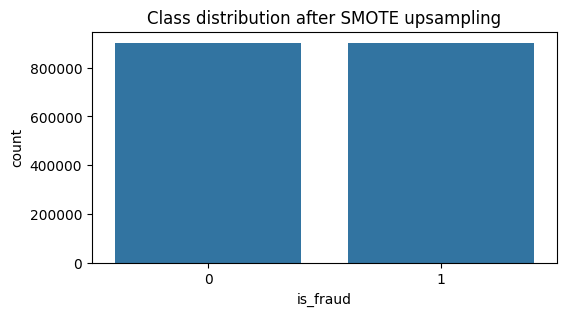

In [94]:
plt.figure(figsize=(6,3))
sns.countplot(x=y_train)
plt.xlabel("is_fraud")
plt.title("Class distribution after SMOTE upsampling")
plt.show()

In [95]:
selector_kbest = SelectKBest(score_func=f_classif, k=10)
selector_kbest.fit(X_train, y_train)

print("SelectKBest")
print("Scores:", selector_kbest.scores_)
selected_indices = np.where(selector_kbest.get_support())[0]
selected_names = X_train.columns[selected_indices]
print("Selected feature indices:", selected_indices)
print("Selected feature names:", list(selected_names))

SelectKBest
Scores: [2.47836028e+02 1.22091717e+04 1.49275804e+06 2.67501262e+04
 1.20722586e+02 3.96163495e+02 9.63392706e+00 3.72041012e+01
 2.55430822e+01 2.87251967e+03 1.13237195e+04 1.05966328e+03
 1.40360630e+04 1.02694271e+04 1.18895177e+01]
Selected feature indices: [ 0  1  2  3  5  9 10 11 12 13]
Selected feature names: ['merchant', 'category', 'amount', 'gender', 'city', 'unix_time', 'trans_hour', 'trans_day', 'trans_month', 'birth_year']


# Step 5 : Model training

In [96]:
def objective(trial, epochs=500, patience=50, val_margin=1e-4):
    # Hyperparameters to optimize
    params = {
        "objective": "multiclass",
        "num_class": len(all_y_labels),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 15, 63),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.7, 1.0),
        "metric": "multi_logloss",
        "verbosity": -1
    }

    # Train with Optuna pruning
    model = lgb.LGBMClassifier(**params, n_estimators=epochs)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="multi_logloss",
        callbacks=[
            lgb.early_stopping(stopping_rounds=patience, first_metric_only=True, min_delta=val_margin),
            LightGBMPruningCallback(trial, metric="multi_logloss"),
        ],
    )

    # Best validation score
    preds = model.predict_proba(X_val)
    loss = log_loss(y_val, preds)
    return loss 

In [97]:
obj = partial(objective, epochs=100, patience=10, val_margin=1e-3)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(obj, n_trials=10)

print("Best validation loss:", study.best_value)
print("Best parameters:", study.best_params)

[I 2025-11-22 00:52:00,498] A new study created in memory with name: no-name-a5262feb-b7c1-4756-a43d-9445169e73f8


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.270092
Evaluated only: multi_logloss


[I 2025-11-22 00:52:11,435] Trial 0 finished with value: 0.27009180608054384 and parameters: {'learning_rate': 0.013499994566042613, 'num_leaves': 55, 'max_depth': 12, 'min_data_in_leaf': 19, 'feature_fraction': 0.7511069569199413, 'bagging_fraction': 0.9838967411291825}. Best is trial 0 with value: 0.27009180608054384.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.153218
Evaluated only: multi_logloss


[I 2025-11-22 00:52:20,163] Trial 1 finished with value: 0.1532175527366368 and parameters: {'learning_rate': 0.029319007938828877, 'num_leaves': 53, 'max_depth': 8, 'min_data_in_leaf': 77, 'feature_fraction': 0.8031758311174886, 'bagging_fraction': 0.9762330157502416}. Best is trial 1 with value: 0.1532175527366368.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.0748454
Evaluated only: multi_logloss


[I 2025-11-22 00:52:27,921] Trial 2 finished with value: 0.07484544820178618 and parameters: {'learning_rate': 0.07715653197149622, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 19, 'feature_fraction': 0.8797827533881942, 'bagging_fraction': 0.954106808078756}. Best is trial 2 with value: 0.07484544820178618.


Training until validation scores don't improve for 10 rounds


[I 2025-11-22 00:52:32,218] Trial 3 finished with value: 0.24195626313733845 and parameters: {'learning_rate': 0.030392395422038674, 'num_leaves': 40, 'max_depth': 3, 'min_data_in_leaf': 79, 'feature_fraction': 0.7552226300573364, 'bagging_fraction': 0.8968242306934726}. Best is trial 2 with value: 0.07484544820178618.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.241956
Evaluated only: multi_logloss
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.239865
Evaluated only: multi_logloss


[I 2025-11-22 00:52:38,925] Trial 4 finished with value: 0.23986517001305754 and parameters: {'learning_rate': 0.016957863024224463, 'num_leaves': 23, 'max_depth': 8, 'min_data_in_leaf': 52, 'feature_fraction': 0.9150761436012366, 'bagging_fraction': 0.7574766847308976}. Best is trial 2 with value: 0.07484544820178618.


Training until validation scores don't improve for 10 rounds


[I 2025-11-22 00:52:43,203] Trial 5 finished with value: 0.1976994216052372 and parameters: {'learning_rate': 0.050254790739939076, 'num_leaves': 18, 'max_depth': 3, 'min_data_in_leaf': 17, 'feature_fraction': 0.9284965759563186, 'bagging_fraction': 0.8740291978649448}. Best is trial 2 with value: 0.07484544820178618.


Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.197699
Evaluated only: multi_logloss


[I 2025-11-22 00:52:43,587] Trial 6 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's multi_logloss: 0.100179
Evaluated only: multi_logloss


[I 2025-11-22 00:52:51,262] Trial 7 finished with value: 0.1001786581771657 and parameters: {'learning_rate': 0.06270530239406906, 'num_leaves': 40, 'max_depth': 7, 'min_data_in_leaf': 53, 'feature_fraction': 0.7367832796357876, 'bagging_fraction': 0.7198801225655634}. Best is trial 2 with value: 0.07484544820178618.


Training until validation scores don't improve for 10 rounds


[I 2025-11-22 00:52:52,258] Trial 8 pruned. Trial was pruned at iteration 17.
[I 2025-11-22 00:52:52,685] Trial 9 pruned. Trial was pruned at iteration 0.


Best validation loss: 0.07484544820178618
Best parameters: {'learning_rate': 0.07715653197149622, 'num_leaves': 23, 'max_depth': 10, 'min_data_in_leaf': 19, 'feature_fraction': 0.8797827533881942, 'bagging_fraction': 0.954106808078756}


In [98]:
optuna.visualization.plot_optimization_history(study)

In [99]:
optuna.visualization.plot_param_importances(study)

In [100]:
best_params = study.best_params
# Train with Optuna pruning
model = lgb.LGBMClassifier(**best_params, n_estimators=500)
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, first_metric_only=True, min_delta=1e-4),
    ],
)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[492]	valid_0's binary_logloss: 0.0120701
Evaluated only: binary_logloss


LGBMClassifier(bagging_fraction=0.954106808078756,
               feature_fraction=0.8797827533881942,
               learning_rate=0.07715653197149622, max_depth=10,
               min_data_in_leaf=19, n_estimators=500, num_leaves=23)

# Step 6 : Evaluation Metrics

In [101]:
y_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

In [102]:
print(f"Overall accuracy test: {accuracy_score(y_test, y_pred):.4%}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Overall accuracy test: 99.7969%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    193326
           1       0.84      0.83      0.83      1176

    accuracy                           1.00    194502
   macro avg       0.92      0.91      0.91    194502
weighted avg       1.00      1.00      1.00    194502



Confusion Matrix:



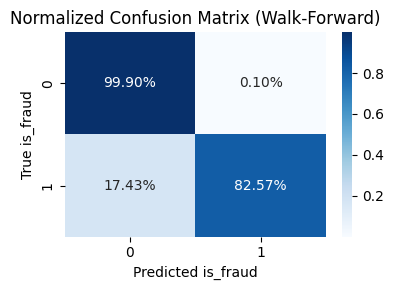

In [103]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", )
plt.figure(figsize=(4, 3))
sns.heatmap(
    cm / cm.sum(axis=1, keepdims=True),
    annot=True,
    fmt=".2%",
    cmap='Blues',
    xticklabels=encoders[target].classes_,
    yticklabels=encoders[target].classes_
)
plt.title("Normalized Confusion Matrix (Walk-Forward)")
plt.xlabel(f"Predicted {target}")
plt.ylabel(f"True {target}")
plt.tight_layout()
plt.show()

In [104]:
# Sensitivity/Recall, Precision, Specificity, etc. globally
TP = np.trace(cm)                     # sum of diagonal = correctly predicted
FP = cm.sum(axis=0) - np.diag(cm)     # false positives per predicted
FN = cm.sum(axis=1) - np.diag(cm)     # false negatives per actual
TN = cm.sum() - (TP + FP.sum() + FN.sum() - TP)  # total - all others

sensitivity = TP / (TP + FN.sum())    # overall recall
precision = TP / (TP + FP.sum())      # overall precision
specificity = TN / (TN + FP.sum())    # overall specificity
print(f"  Sensitivity / Recall: {sensitivity:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Specificity: {specificity:.3f}")

  Sensitivity / Recall: 0.998
  Precision: 0.998
  Specificity: 0.998


ROC AUC Score:  0.9123487381048444


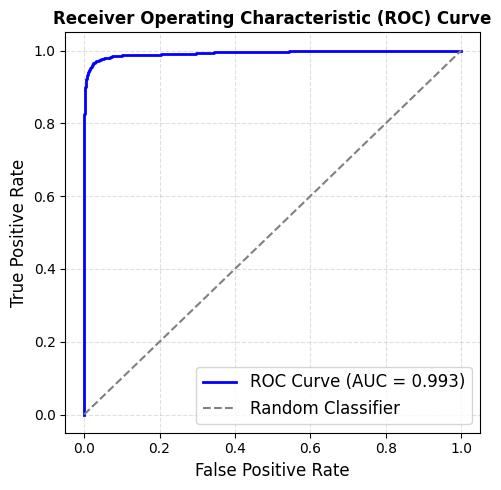

In [105]:
print("ROC AUC Score: ", roc_auc_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1], color='gray', linestyle='--', label="Random Classifier")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontweight="bold")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()

In [106]:
print(f"MSE (Probabilities vs True): {mean_squared_error(y_test, y_prob[:,1]):.4f}")

MSE (Probabilities vs True): 0.0018


<Figure size 1200x500 with 0 Axes>

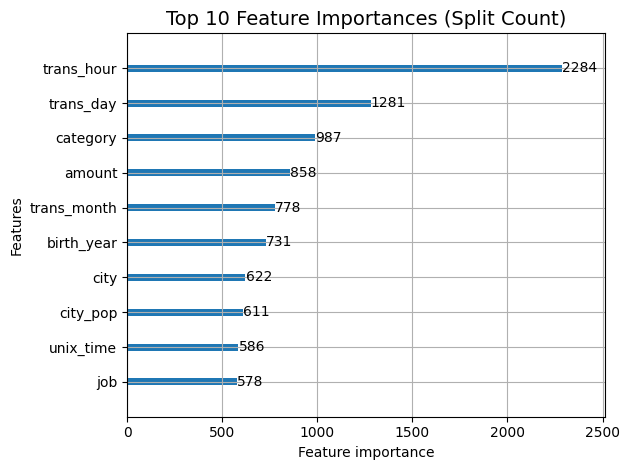

In [107]:
plt.figure(figsize=(12, 5))
lgb.plot_importance(model, max_num_features=10, importance_type='split')
plt.title("Top 10 Feature Importances (Split Count)", fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 800x500 with 0 Axes>

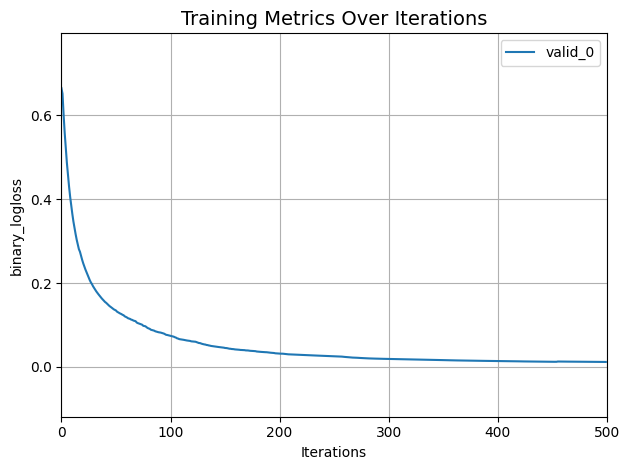

In [108]:
plt.figure(figsize=(8,5))
lgb.plot_metric(model)
plt.title("Training Metrics Over Iterations", fontsize=14)
plt.tight_layout()
plt.show()

In [109]:
print(model.booster_.dump_model()["tree_info"][0])

{'tree_index': 0, 'num_leaves': 23, 'num_cat': 0, 'shrinkage': 0.0771565, 'tree_structure': {'split_index': 0, 'split_feature': 10, 'split_gain': 135190, 'threshold': 0.5833336055399345, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': 0, 'internal_weight': 451226, 'internal_count': 1804902, 'left_child': {'split_index': 1, 'split_feature': 10, 'split_gain': 37770.6015625, 'threshold': -0.8333342583388502, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': -0.0219757, 'internal_weight': 355083, 'internal_count': 1420331, 'left_child': {'split_index': 2, 'split_feature': 10, 'split_gain': 27054.80078125, 'threshold': -1.1666331486230128, 'decision_type': '<=', 'default_left': True, 'missing_type': 'None', 'internal_value': 0.0279526, 'internal_weight': 71928.2, 'internal_count': 287713, 'left_child': {'leaf_index': 0, 'leaf_value': -0.09702636015842307, 'leaf_weight': 9018.5, 'leaf_count': 36074}, 'right_child': {

In [110]:
def pretty_tree(node, prefix=""):
    if "leaf_value" in node:
        print(prefix + Fore.GREEN + f"◆ Leaf: value = {node['leaf_value']:.5f}" + Style.RESET_ALL)
        return
    feature = node["split_feature"]
    threshold = node["threshold"]
    print(prefix + Fore.CYAN + f"● Feature[{feature}] <= {threshold}" + Style.RESET_ALL)
    print(prefix + "   ├── " + Fore.YELLOW + "Left:" + Style.RESET_ALL)
    pretty_tree(node["left_child"], prefix + "   │    ")
    print(prefix + "   └── " + Fore.YELLOW + "Right:" + Style.RESET_ALL)
    pretty_tree(node["right_child"], prefix + "        ")

tree = model.booster_.dump_model()["tree_info"][0]["tree_structure"]
pretty_tree(tree)

● Feature[10] <= 0.5833336055399345
   ├── Left:
   │    ● Feature[10] <= -0.8333342583388502
   │       ├── Left:
   │       │    ● Feature[10] <= -1.1666331486230128
   │       │       ├── Left:
   │       │       │    ◆ Leaf: value = -0.09703
   │       │       └── Right:
   │       │            ● Feature[10] <= -1.0833355048458875
   │       │               ├── Left:
   │       │               │    ◆ Leaf: value = 0.15431
   │       │               └── Right:
   │       │                    ● Feature[10] <= -1.0833200368121856
   │       │                       ├── Left:
   │       │                       │    ◆ Leaf: value = -0.08081
   │       │                       └── Right:
   │       │                            ● Feature[10] <= -1.0000029272417719
   │       │                               ├── Left:
   │       │                               │    ◆ Leaf: value = 0.15431
   │       │                               └── Right:
   │       │                                    ● F

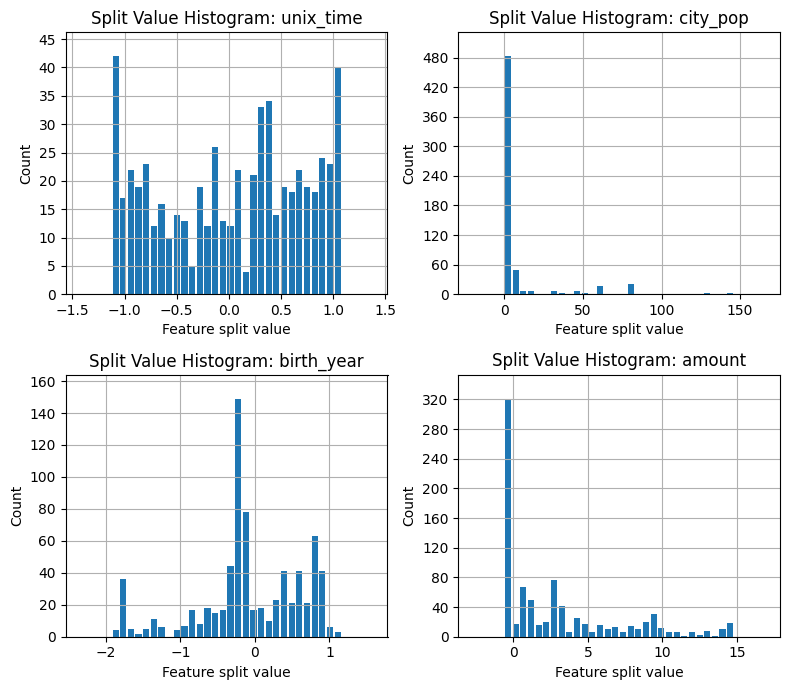

In [111]:
to_plot_features = ["unix_time", "city_pop", "birth_year", "amount"] # 4 most important continuous features
fig, axes = plt.subplots(2, 2, figsize=(8, 7))
axes = axes.ravel()  # flatten to 1D iterator
for ax, feat in zip(axes, to_plot_features):
    lgb.plot_split_value_histogram(model, feature=feat, bins=30, ax=ax)
    ax.set_title(f"Split Value Histogram: {feat}", fontsize=12)
plt.tight_layout()
plt.show()

In [113]:
joblib.dump(model, "data/fraud_detection_model/model.jb")
joblib.dump(encoders, "data/fraud_detection_model/label_encoders.jb")
joblib.dump(scalers, "data/fraud_detection_model/scalers_encoder.jb")

['data/fraud_detection_model/scalers_encoder.jb']